In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import joblib

from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

/home/local/VANDERBILT/lij112/.local/lib/python3.10/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
btc_candles_csv = "data/raw/btc_usd_900s_candles.csv"
coindesk_news_csv = "data/raw/coindesk_news_sentiment.csv"
social_btc_daily_csv = "data/raw/social_btc_daily.csv"
btc_candles_social_csv = "data/raw/btc_usd_900s_candles_social.csv"
btc_candles_cleaned_csv = "data/raw/btc_usd_900s_candles_cleaned.csv"
btc_candles_cleaned_parq = "data/features/raw_features.parquet"
btc_candles_labeled_npy = "data/features/labels.npy"
btc_candles_labeled_column = "data/features/labels_column.txt"
btc_candles_normalized_npy = "data/features/processed_features.npy"
btc_candles_normalized_column = "data/features/processed_features_column.txt"
btc_candles_scaler = "data/features/scaler.joblib"

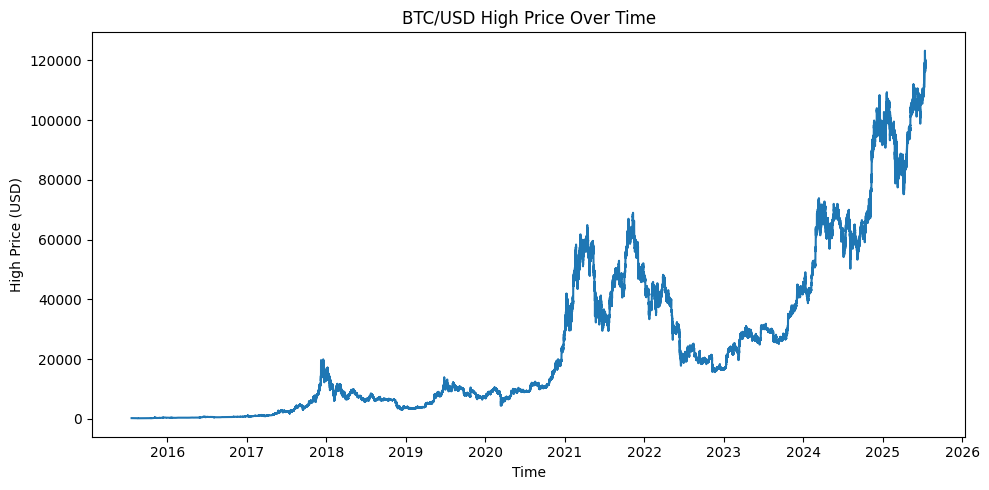

In [ ]:
btc_candles_df = pd.read_csv(btc_candles_csv)
btc_candles_df = btc_candles_df.sort_values(by="time")
btc_candles_df = btc_candles_df.drop_duplicates(subset="time")
btc_candles_df.to_csv(btc_candles_csv, index=False)

btc_candles_df["datetime"] = pd.to_datetime(btc_candles_df["time"], unit="s")
plt.figure(figsize=(10, 5))
plt.plot(btc_candles_df["datetime"], btc_candles_df["high"])
plt.xlabel("Time")
plt.ylabel("High Price (USD)")
plt.title("BTC/USD High Price Over Time")
plt.tight_layout()
plt.show()

Compute weekly sentiment: 100%|██████████| 350013/350013 [00:00<00:00, 401305.92it/s]


Done computing sentiment index.


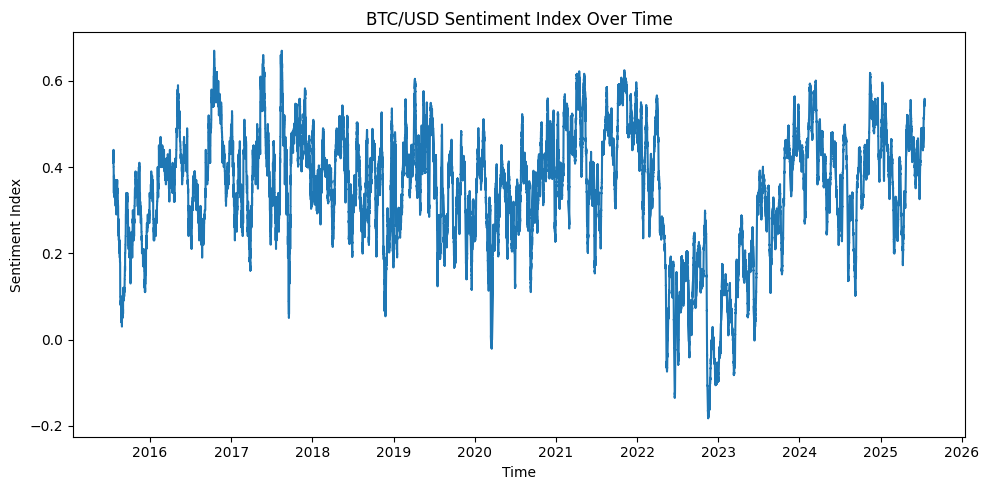

In [56]:
btc_candles_df = pd.read_csv(btc_candles_csv)
coindesk_news_df = pd.read_csv(coindesk_news_csv)

coindesk_news_df["published_on"] = coindesk_news_df["published_on"].astype("int64")
btc_candles_df["time"] = btc_candles_df["time"].astype("int64")

mapping = {"positive": 1, "negative": -1, "neutral": 0}
coindesk_news_df["score"] = (
    coindesk_news_df["sentiment"].str.lower().map(mapping).fillna(0).astype("int8")
)

coindesk_news_df.sort_values("published_on", inplace=True, ignore_index=True)

pub_times = coindesk_news_df["published_on"].values
score = coindesk_news_df["score"].values
is_pos = (score == 1).astype(np.int32)
is_neg = (score == -1).astype(np.int32)

cum_tot = np.cumsum(np.ones_like(score, dtype=np.int32))
cum_pos = np.cumsum(is_pos)
cum_neg = np.cumsum(is_neg)


def range_counts(left_idx, right_idx):
    if left_idx == 0:
        tot = cum_tot[right_idx]
        pos = cum_pos[right_idx]
        neg = cum_neg[right_idx]
    else:
        tot = cum_tot[right_idx] - cum_tot[left_idx - 1]
        pos = cum_pos[right_idx] - cum_pos[left_idx - 1]
        neg = cum_neg[right_idx] - cum_neg[left_idx - 1]
    return pos, neg, tot


WEEK_SEC = 7 * 24 * 3600
MIN_ROWS = 100
sent_idx = []

for t in tqdm(btc_candles_df["time"], desc="Compute weekly sentiment"):
    r = np.searchsorted(pub_times, t, side="right") - 1
    if r < 0:
        sent_idx.append(0.0)
        continue
    l = np.searchsorted(pub_times, t - WEEK_SEC, side="left")
    need = MIN_ROWS - (r - l + 1)
    if need > 0:
        l = max(0, l - need)
    pos, neg, tot = range_counts(l, r)
    index = (pos - neg) / tot if tot else 0.0
    sent_idx.append(index)

btc_candles_df["sentiment_index"] = sent_idx
btc_candles_df.to_csv(btc_candles_csv, index=False)
print("Done computing sentiment index.")

btc_candles_df["datetime"] = pd.to_datetime(btc_candles_df["time"], unit="s")
plt.figure(figsize=(10, 5))
plt.plot(btc_candles_df["datetime"], btc_candles_df["sentiment_index"])
plt.xlabel("Time")
plt.ylabel("Sentiment Index")
plt.title("BTC/USD Sentiment Index Over Time")
plt.tight_layout()
plt.show()

In [14]:
social_btc_daily_df = pd.read_csv(social_btc_daily_csv)
social_btc_daily_df.sort_values("time", inplace=True, ignore_index=True)

zero_counts = social_btc_daily_df.eq(0).sum()

print("\nZero-count per column:")
for col, cnt in zero_counts.items():
    print(f"{col:<25}: {cnt}")

cols_to_keep = zero_counts[zero_counts < 50].index.tolist()
social_btc_daily_df = social_btc_daily_df[cols_to_keep]

print(f"\nKept {len(cols_to_keep)} column(s) with <50 zeros:")
print(cols_to_keep)
social_btc_daily_df.to_csv("data_csv/social_btc_daily_filtered.csv", index=False)


Zero-count per column:
time                     : 0
code_repo_stars          : 0
code_repo_forks          : 0
code_repo_subscribers    : 0
code_repo_open_pull_issues: 0
code_repo_closed_pull_issues: 0
code_repo_open_issues    : 0

Kept 7 column(s) with <50 zeros:
['time', 'code_repo_stars', 'code_repo_forks', 'code_repo_subscribers', 'code_repo_open_pull_issues', 'code_repo_closed_pull_issues', 'code_repo_open_issues']


In [ ]:
btc_candles_df = pd.read_csv(btc_candles_csv)
social_btc_daily_df = pd.read_csv(social_btc_daily_csv)

CUT_TS = 1495756800
btc_candles_df = btc_candles_df[btc_candles_df["time"] >= CUT_TS].copy()

btc_candles_df.sort_values("time", inplace=True, ignore_index=True)
social_btc_daily_df.sort_values("time", inplace=True, ignore_index=True)
btc_candles_social_df = pd.merge_asof(
    btc_candles_df,
    social_btc_daily_df,
    on="time",
    direction="backward",
)
btc_candles_social_df.to_csv(btc_candles_social_csv, index=False)

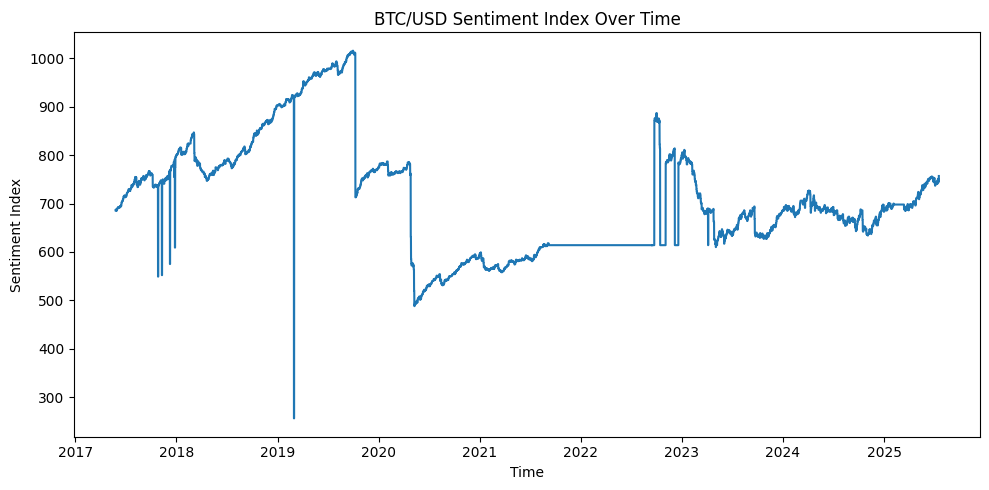

In [ ]:
btc_candles_social_df = pd.read_csv(btc_candles_social_csv)
btc_candles_social_df["datetime"] = pd.to_datetime(
    btc_candles_social_df["time"], unit="s"
)
plt.figure(figsize=(10, 5))
plt.plot(
    btc_candles_social_df["datetime"], btc_candles_social_df["code_repo_open_issues"]
)
plt.xlabel("Time")
plt.ylabel("Sentiment Index")
plt.title("BTC/USD Sentiment Index Over Time")
plt.tight_layout()
plt.show()

In [ ]:
btc_candles_df = pd.read_csv(btc_candles_csv)
btc_candles_df["datetime"] = pd.to_datetime(btc_candles_df["time"], unit="s", utc=True)
btc_candles_df.set_index("datetime", inplace=True)

ohlc = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum",
}
btc_candles_indicator_df = btc_candles_df.resample("1D").agg(ohlc).dropna(how="any")

btc_candles_indicator_df["ema10"] = ta.ema(btc_candles_indicator_df["close"], length=10)
btc_candles_indicator_df["ema40"] = ta.ema(btc_candles_indicator_df["close"], length=40)
btc_candles_indicator_df["ema_slope"] = btc_candles_indicator_df["ema10"].pct_change(1)

macd = ta.macd(btc_candles_indicator_df["close"], fast=12, slow=26, signal=9)
btc_candles_indicator_df = btc_candles_indicator_df.join(macd)
btc_candles_indicator_df.rename(
    columns={
        "MACD_12_26_9": "macd",
        "MACDh_12_26_9": "macd_hist",
        "MACDs_12_26_9": "macd_signal",
    },
    inplace=True,
)

btc_candles_indicator_df["rsi14"] = ta.rsi(btc_candles_indicator_df["close"], length=14)

if True:
    ind_15m = btc_candles_indicator_df.reindex(btc_candles_df.index, method="ffill")
    btc_candles_merged_df = btc_candles_df.join(
        ind_15m[
            ["ema10", "ema40", "ema_slope", "macd", "macd_hist", "macd_signal", "rsi14"]
        ]
    )
    btc_candles_merged_df.to_csv(btc_candles_csv, index=False)
    print(f"Saved merged 15-min data")

Saved realized volatility.


In [ ]:
btc_candles_df = pd.read_csv(btc_candles_csv)
btc_candles_df["datetime"] = pd.to_datetime(btc_candles_df["time"], unit="s", utc=True)
btc_candles_df.set_index("datetime", inplace=True)

log_ret = np.log(btc_candles_df["close"]).diff()

WINDOWS = {
    "realvol_7d": 7 * 24 * 4,
    "realvol_30d": 30 * 24 * 4,
    "realvol_60d": 60 * 24 * 4,
}
ANN_FACTOR = np.sqrt(365 * 24 * 4)

for col, win in WINDOWS.items():
    real_var = log_ret.rolling(win, min_periods=win).apply(
        lambda x: np.dot(x, x), raw=True
    )
    btc_candles_df[col] = np.sqrt(real_var) * ANN_FACTOR

btc_candles_df.to_csv(btc_candles_csv, index=False)
print("Saved realized volatility.")

Saved realized volatility.


In [ ]:
btc_candles_df = pd.read_csv(btc_candles_csv)
btc_metrics_df = pd.read_csv("data_csv/btc_metrics_grass_merged.csv")
macro_liq_df = pd.read_csv("data_csv/macro_liquidity.csv")

btc_candles_df["datetime"] = pd.to_datetime(btc_candles_df["time"], unit="s", utc=True)
btc_candles_df.set_index("datetime", inplace=True)

btc_metrics_df["datetime"] = pd.to_datetime(
    btc_metrics_df["timestamp"], unit="s", utc=True
)
btc_metrics_df.sort_values("datetime", inplace=True)

macro_liq_df["datetime"] = pd.to_datetime(macro_liq_df["timestamp"], unit="s", utc=True)
macro_liq_df.sort_values("datetime", inplace=True)

na_count = btc_metrics_df.isna().sum().sort_values(ascending=False)
print(">>> Null count in btc_metrics_df (top 10):")
print(na_count.head(10))

candles_idx = btc_candles_df.index.to_series().reset_index(drop=True).rename("datetime")

metrics_aligned = pd.merge_asof(
    candles_idx, btc_metrics_df, on="datetime", direction="backward"
).drop(columns="timestamp")

macro_aligned = pd.merge_asof(
    candles_idx, macro_liq_df, on="datetime", direction="backward"
).drop(columns="timestamp")

btc_candles_merged = btc_candles_df.copy()
btc_candles_merged.reset_index(inplace=True)

btc_candles_merged = btc_candles_merged.join(
    metrics_aligned.drop(columns="datetime")
).join(macro_aligned.drop(columns="datetime"))

btc_candles_merged.sort_values("datetime", inplace=True)
btc_candles_merged.ffill(inplace=True)

btc_candles_merged.drop(columns="datetime", inplace=True)
btc_candles_merged.to_csv(btc_candles_csv, index=False)
print("Merged shape:", btc_candles_merged.shape)

>>> Null count in btc_metrics_df (top 10):
sopr                      12
transaction_size_mean     12
timestamp                  0
difficulty_ribbon_ma40     0
active_addresses           0
block_interval_mean        0
transaction_count          0
supply_last_active         0
fees_total                 0
transfers_volume_total     0
dtype: int64
Merged shape: (350013, 46)


In [ ]:
btc_candles_df = pd.read_csv(btc_candles_csv)
print(f"Reading {btc_candles_csv} …")
df = pd.read_csv(btc_candles_csv)

missing_idxs = df.index[df.isna().any(axis=1)].tolist()
print(f"Total rows with at least one NaN: {len(missing_idxs)}")

# collapse into ranges
ranges = []
if missing_idxs:
    start = prev = missing_idxs[0]
    for idx in missing_idxs[1:]:
        if idx == prev + 1:  # consecutive
            prev = idx
            continue
        # close current range
        ranges.append((start, prev))
        start = prev = idx
    ranges.append((start, prev))  # last range

# pretty-print
for s, e in ranges:
    if s == e:
        print(f"Row {s} has missing values")
    else:
        print(f"Rows {s}-{e} have missing values")

clean_df = df.dropna(how="any").reset_index(drop=True)
clean_df.to_csv(btc_candles_cleaned_csv, index=False)
print(f"\nSaved cleaned file: {btc_candles_cleaned_csv}")
print("Clean shape:", clean_df.shape)

Reading data_csv/btc_usd_900s_candles.csv …
Total rows with at least one NaN: 5760
Rows 0-5759 have missing values

Saved cleaned file: data_csv/btc_usd_900s_candles_clean.csv
Clean shape: (344253, 46)


In [7]:
btc_candles_parq = Path(btc_candles_csv).with_suffix(".parquet")
pd.read_csv(btc_candles_cleaned_csv).to_parquet(
    btc_candles_parq, index=False, compression="zstd"
)
print("Saved", btc_candles_parq)

btc_candles_social_parq = Path(btc_candles_social_csv).with_suffix(".parquet")
pd.read_csv(btc_candles_social_csv).to_parquet(
    btc_candles_social_parq, index=False, compression="zstd"
)
print("Saved", btc_candles_social_parq)

btc_candles_cleaned_parq = Path(btc_candles_cleaned_csv).with_suffix(".parquet")
pd.read_csv(btc_candles_cleaned_csv).to_parquet(
    btc_candles_cleaned_parq, index=False, compression="zstd"
)
print("Saved", btc_candles_cleaned_parq)

Saved data_csv/btc_usd_900s_candles.parquet
Saved data_csv/btc_usd_900s_candles_social.parquet
Saved data_csv/btc_usd_900s_candles_cleaned.parquet


In [ ]:
BAR_PER_DAY = 96
SHIFT_90D = BAR_PER_DAY * 90
SHIFT_30D = BAR_PER_DAY * 30

btc_candles_cleaned_df = pd.read_parquet(btc_candles_cleaned_parq)
close = btc_candles_cleaned_df["close"].values

r90 = np.log(close[SHIFT_90D:] / close[:-SHIFT_90D])
log_ret = np.log(close[1:] / close[:-1])
realvol30 = (
    pd.Series(log_ret)
    .rolling(window=SHIFT_30D, min_periods=SHIFT_30D)
    .std()
    .shift(-SHIFT_30D + 1)
    .values
)

r90_series = pd.Series(r90)
p90 = (
    r90_series.rolling(window=SHIFT_90D, min_periods=SHIFT_90D)
    .quantile(0.9)
    .shift(-SHIFT_90D + 1)
    .values
)
p10 = (
    r90_series.rolling(window=SHIFT_90D, min_periods=SHIFT_90D)
    .quantile(0.1)
    .shift(-SHIFT_90D + 1)
    .values
)

btc_candles_cleaned_df = btc_candles_cleaned_df.iloc[:-SHIFT_90D].copy()
btc_candles_cleaned_df["r90"] = r90
btc_candles_cleaned_df["sigma30_real"] = realvol30[: len(btc_candles_cleaned_df)]
btc_candles_cleaned_df["p90"] = p90[: len(btc_candles_cleaned_df)]
btc_candles_cleaned_df["p10"] = p10[: len(btc_candles_cleaned_df)]

btc_candles_cleaned_df["cls"] = 1
btc_candles_cleaned_df.loc[btc_candles_cleaned_df["r90"] > 0.05, "cls"] = 0
btc_candles_cleaned_df.loc[btc_candles_cleaned_df["r90"] < -0.05, "cls"] = 2

btc_candles_cleaned_df.dropna(inplace=True)
labels = btc_candles_cleaned_df[["cls", "p90", "p10", "sigma30_real"]].to_numpy()
np.save(btc_candles_labeled_npy, labels)
print("Saved labels array.")

with open(btc_candles_labeled_column, "w") as f:
    for col in ["cls", "p90", "p10", "sigma30_real"]:
        f.write(col + "\n")
print("Saved label columns list.")

Saved labels array.
Saved label columns list.


In [3]:
btc_candles_cleaned_df = pd.read_parquet(btc_candles_cleaned_parq)
btc_candles_cleaned_df["datetime"] = pd.to_datetime(
    btc_candles_cleaned_df["time"], unit="s", utc=True
)
btc_candles_cleaned_df = btc_candles_cleaned_df.set_index("datetime").sort_index()

for c in [
    "open",
    "high",
    "low",
    "close",
    "time",
    "realvol_7d",
    "realvol_30d",
    "realvol_60d",
]:
    if c in btc_candles_cleaned_df.columns:
        btc_candles_cleaned_df.drop(columns=c, inplace=True)

hours = btc_candles_cleaned_df.index.hour.values
dow = btc_candles_cleaned_df.index.dayofweek.values
btc_candles_cleaned_df["hour_sin"] = np.sin(2 * np.pi * hours / 24)
btc_candles_cleaned_df["hour_cos"] = np.cos(2 * np.pi * hours / 24)
btc_candles_cleaned_df["dow_sin"] = np.sin(2 * np.pi * dow / 7)
btc_candles_cleaned_df["dow_cos"] = np.cos(2 * np.pi * dow / 7)

log_cols = [
    "volume",
    "market_cap",
    "hash_rate",
    "mining_difficulty",
    "utxo_value_spent_total",
    "blocks_mined",
    "transaction_count",
    "transfers_volume_total",
    "fees_total",
    "active_addresses",
    "utxos_spent",
]
identity_cols = [
    "sentiment_index",
    "ema10",
    "ema40",
    "ema_slope",
    "macd",
    "macd_hist",
    "macd_signal",
    "rsi14",
    "transaction_size_mean",
    "sopr",
    "supply_last_active",
    "stock_to_flow_ratio_ratio",
    "stock_to_flow_ratio_price",
    "stock_to_flow_ratio_daysTillHalving",
    "difficulty_ribbon_ma9",
    "difficulty_ribbon_ma14",
    "difficulty_ribbon_ma25",
    "difficulty_ribbon_ma40",
    "difficulty_ribbon_ma60",
    "difficulty_ribbon_ma90",
    "difficulty_ribbon_ma128",
    "difficulty_ribbon_ma200",
    "block_interval_mean",
]
macro_cols = ["dxy", "yield10", "yield2", "yield_spread"]
cyclical_cols = ["hour_sin", "hour_cos", "dow_sin", "dow_cos"]

all_cols = set(btc_candles_cleaned_df.columns)
for grp, cols in [
    ("log", log_cols),
    ("id", identity_cols),
    ("macro", macro_cols),
    ("cyc", cyclical_cols),
]:
    missing = set(cols) - all_cols
    if missing:
        raise KeyError(f"Missing columns for {grp}: {missing}")


def log1p_transform(x):
    import numpy as np

    return np.log1p(x)


log_tf = FunctionTransformer(log1p_transform, validate=False)
preprocessor = ColumnTransformer(
    transformers=[
        ("log", Pipeline([("log", log_tf), ("robust", RobustScaler())]), log_cols),
        ("std", StandardScaler(), identity_cols + macro_cols),
        ("cyc", "passthrough", cyclical_cols),
    ],
    remainder="drop",
)

btc_candles_cleaned_df = btc_candles_cleaned_df.dropna(
    subset=log_cols + identity_cols + macro_cols + cyclical_cols
)

print("Fitting & transforming features ...")
X = preprocessor.fit_transform(btc_candles_cleaned_df)

np.save(btc_candles_normalized_npy, X)
print("Saved features matrix.")

cols = log_cols + identity_cols + macro_cols + cyclical_cols
with open(btc_candles_normalized_column, "w") as f:
    for c in cols:
        f.write(c + "\n")
print("Saved feature columns list.")

joblib.dump(preprocessor, btc_candles_scaler)
print("Saved fitted scaler.")

Fitting & transforming features ...
Saved features matrix.
Saved feature columns list.
Saved fitted scaler.
